In [1]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib unidecode unidecode beautifulsoup4 > /dev/null # dev null esconde output

In [3]:
## Essa celula obtem a lista de artistas utilizando a api do last.fm

import requests
import time
import os

genius_token = os.getenv("GENIUSTOKEN")
if not genius_token:
    raise ValueError("Missing genius API key. Set the GENIUSTOKEN environment variable.")


API_KEY =  os.getenv("LASTFMKEY")
if not API_KEY:
    raise ValueError("Missing last.fm API key. Set the LASTFMKEY environment variable.")


BASE_URL = 'http://ws.audioscrobbler.com/2.0/'
LIMIT_PER_PAGE = 100 # 100 is the max
TOTAL_ARTISTS = 100000

tags = ["brasil", "brazil", "brazilian", "brazilian music", "musica brasileira"]
number_artists_per_tag = [5000, 5000, 5000, 5000, 5000] ## com esses numeros, considerando 0 overlap, 
#50 musicas por artista o total de tempo de busca das letras seria de 14 dias 

# tags = ["mpb"]
# number_artists_per_tag = [100] #todos os numeros precisamos maior que 100

def get_top_artists_by_tag(tag, total_artists=300):
    print("total artists", total_artists)
    all_artists = []
    pages_needed = total_artists // LIMIT_PER_PAGE

    for page in range(1, pages_needed + 1):
        params = {
            'method': 'tag.getTopArtists',
            'tag': tag,
            'api_key': API_KEY,
            'format': 'json',
            'limit': LIMIT_PER_PAGE,
            'page': page
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            data = response.json()
            artists = data.get('topartists', {}).get('artist', [])
            for artist in artists:
                all_artists.append(artist['name'])
        else:
            print(f"Erro ao buscar página {page}: status {response.status_code}")
        time.sleep(0.2)  # evitar sobrecarga na API

    return all_artists


def merge_unique_artists(artist_lists):
    merged = []
    seen = set()
    for artist_list in artist_lists:
        for artist in artist_list:
            if artist not in seen:
                seen.add(artist)
                merged.append(artist)
    return merged


def get_artists_by_tags(tags, number_per_tag):
    print("Getting Artists")
    all_artist_lists = []
    i = 0
    for tag in tags:
        tag_amount = number_per_tag[i]
        print("Tag Amount" , tag_amount)
        print(f"Fetching artists for tag: {tag}")
        artist_list = get_top_artists_by_tag(tag, tag_amount)
        all_artist_lists.append(artist_list)
        i += 1

    return merge_unique_artists(all_artist_lists)

artist_list = get_artists_by_tags(tags, number_artists_per_tag)
#artist_list

Getting Artists
Tag Amount 100
Fetching artists for tag: mpb
total artists 100


In [4]:
##This cell gets lyrics
from getpass import getpass
from bs4 import BeautifulSoup
import json

artists = artist_list

BASE_URL = 'http://ws.audioscrobbler.com/2.0/'


def get_top_tracks(artist_name):
    params = {
        'method': 'artist.getTopTracks',
        'artist': artist_name,
        'api_key': API_KEY,
        'format': 'json',
        'limit': 50 ## 50 eh o default
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        tracks = data.get('toptracks', {}).get('track', [])
        # Ensure tracks is a list
        if isinstance(tracks, dict):
            tracks = [tracks]
        return [track['name'] for track in tracks]
    else:
        print(f"Error fetching tracks for {artist_name}: {response.status_code}")
        return []

def fetch_lyrics_from_url(song_url):
    """
    Scrapes the lyrics from a Genius song page.
    This is a workaround since the API doesn't return full lyrics.
    """
    try:
        response = requests.get(song_url, timeout=10)
        if response.status_code != 200:
            print(f"Failed to fetch song page: {response.status_code}")
            return ''

        soup = BeautifulSoup(response.text, 'html.parser')
        lyrics_divs = soup.find_all("div", class_=lambda x: x and 'Lyrics__Container-sc-3d1d18a3-1 bjajog' in x)

        lyrics = []
        for div in lyrics_divs:
            #print(div)
            #print("\n \n \n")
            for br in div.find_all("br"):
                br.replace_with("\n")
            lyrics.append(div.get_text(separator="\n"))

        return " ".join(lyrics)#.strip()
    except Exception as e:
        print(f"Error scraping lyrics page: {e}")
        return ''


def search_lyrics_raw(genius_token, artist, title, verbose=True, retries=3, sleep_seconds=2):
    headers = {
        "Authorization": f"Bearer {genius_token}"
    }

    search_query = f"{title} {artist}"
    search_url = "https://api.genius.com/search"
    params = {"q": search_query}

    for attempt in range(1, retries + 1):
        try:
            response = requests.get(search_url, headers=headers, params=params, timeout=10)

            debug_info = {
                "attempt": attempt,
                "status_code": response.status_code,
                "response_text_snippet": response.text[:200],  # first 200 chars for preview
                "url": response.url
            }

            if verbose:
                prisant(f"[Attempt {attempt}] Searching for: {search_query}")
                print(f"Status Code: {response.status_code}")
                print(f"URL: {response.url}")
                print("Response Preview:", response.text[:200])

            if response.status_code == 200:
                data = response.json()
                hits = data.get("response", {}).get("hits", [])
                if hits:
                    # Get the URL of the first matching song
                    song_url = hits[0]["result"]["url"]
                    return fetch_lyrics_from_url(song_url), debug_info
                else:
                    print(f"No results found for: {search_query}")
                    return '', debug_info

            elif response.status_code == 401:
                print("🔒 Unauthorized – check your API token.")
                return '', debug_info

            elif response.status_code == 429:
                print("⏳ Rate limited – too many requests. Try again later.")
                time.sleep(sleep_seconds * attempt)
                continue

            else:
                print(f"⚠️ Unexpected status code: {response.status_code}")
                return '', debug_info

        except requests.exceptions.RequestException as e:
            print(f"❌ Network error on attempt {attempt}: {type(e).__name__}: {e}")
            time.sleep(sleep_seconds * attempt)

    print("❌ Failed all retry attempts.")
    return '', {"error": "Retries exhausted"}


def append_artist_lyrics(filename, artist, lyrics):
    with open(filename, 'a', encoding='utf-8') as f:
        entry = {'artista': artist, 'letra': lyrics}
        json_line = json.dumps(entry, ensure_ascii=False)
        f.write(json_line + '\n')

def get_processed_artists(filename):
    processed = set()
    if os.path.exists(filename):
        with open(filename, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    entry = json.loads(line)
                    processed.add(entry['artista'])
    return processed

checkpoint_file = "processed_artists_checkpoint.txt"
processed_artists = set()

print("EXECUTING SEARCH")
processed_artists = get_processed_artists('musicas.ndjson')
artist_index = 1

for artist in artists[:5]:
    if artist in processed_artists:
        print(f"Skipping already processed artist: {artist}")
        artist_index += 1
        continue

    print(f"Processing artist: {artist}, artist {artist_index}/{len(artists)}")
    top_tracks = get_top_tracks(artist)
    full_lyrics = ''
    for title in top_tracks:
        lyrics, debug_info = search_lyrics_raw(genius_token, artist, title, False)
        if lyrics:
            lyrics = lyrics.replace('\r', '').replace('\n', ' ').strip()
            full_lyrics += ' ' + lyrics
        else:
            print("=== DEBUG INFO ===")
            for k, v in debug_info.items():
                print(f"{k}: {v}")
        time.sleep(0.5)  # Respect API rate limit

    ndjson_filename = "musicas.ndjson"
    append_artist_lyrics('musicas.ndjson', artist, full_lyrics)

    artist_index += 1


EXECUTING SEARCH
Processing artist: ANAVITÓRIA, artist 1/100
Processing artist: Chico Buarque, artist 2/100
Processing artist: Caetano Veloso, artist 3/100
Processing artist: Rita Lee, artist 4/100
Processing artist: Jorge Ben Jor, artist 5/100


In [7]:
ndjson_filename = "musicas.ndjson"
def load_all_lyrics(filename):
    entries = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                entry = json.loads(line)
                entries.append(entry)
    return entries

musicas = load_all_lyrics(ndjson_filename)

In [18]:
dados_artistas = []

nomes_artistas = [m['artista'] for m in musicas]
print(len(nomes_artistas))
for m in musicas:
    letra = m['letra'].lower()  # deixar tudo em minúsculo para comparação
    artista_atual = m['artista'].lower()
    #print(artista_atual)
    citados = []

    for outro in nomes_artistas:
        outro_lower = outro.lower()
        if outro_lower != artista_atual and outro_lower in letra:
            citados.append(outro)

    dados_artistas.append({
        'artista': m['artista'],
        'entidades': citados
    })

artistas_que_citam = [d for d in dados_artistas if d['entidades']]

print("Artistas que citam : ", artistas_que_citam)


5
Artistas que citam :  [{'artista': 'ANAVITÓRIA', 'entidades': ['Rita Lee']}, {'artista': 'Caetano Veloso', 'entidades': ['Rita Lee']}]


In [10]:
# (sem acentos / lower-case)
from unidecode import unidecode

def normalizar(nome: str) -> str:
    return unidecode(nome).lower().strip()

# Índices únicos de artistas + entidades
nomes = list({normalizar(d['artista']) for d in dados_artistas})
indices = {nome: i for i, nome in enumerate(nomes)}


In [11]:
import numpy as np
import pandas as pd

# 7) Construção da matriz de adjacência
def construir_matriz_adj(dados, indices):
    N = len(indices)
    M = np.zeros((N, N), dtype=float)
    for item in dados:
        orig = normalizar(item['artista'])
        i_orig = indices[orig]
        for ent in item['entidades']:
            if ent:
                dest = normalizar(ent)
                j = indices.get(dest)
                if j is not None and j != i_orig:
                    M[j, i_orig] = 1
    return M

matriz_adj = construir_matriz_adj(dados_artistas, indices)




In [12]:
# Inverte o dicionário: índice -> nome
nomes_artistas = [nome for nome, _ in sorted(indices.items(), key=lambda x: x[1])]

# Cria o DataFrame com artistas nas colunas
df_adj = pd.DataFrame(matriz_adj, index=nomes_artistas, columns=nomes_artistas)

#insere primeira linha com o nome dos artistas
nomes_artistas_lst = pd.Series(nomes_artistas) # <-converted to series
pd.concat([pd.Series(nomes_artistas_lst), df_adj], axis=1)


df_adj.to_csv('matriz_adjacencia.csv', index=True)

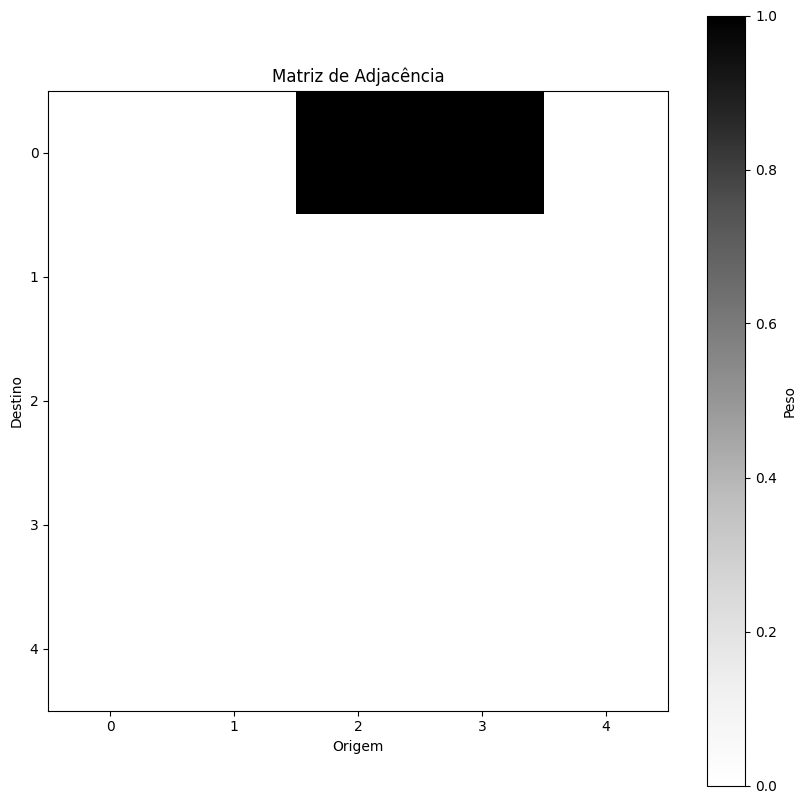

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(matriz_adj, cmap='Greys', interpolation='none')
plt.title('Matriz de Adjacência')
plt.xlabel('Origem')
plt.ylabel('Destino')
plt.colorbar(label='Peso')
plt.show()


In [14]:
# 8) Normalização

def normalizar_colunas(M):
    N = M.shape[0]
    C = np.zeros_like(M)
    for col in range(N):
        s = M[:, col].sum()
        if s == 0:
            C[:, col] = 1.0 / N
        else:
            C[:, col] = M[:, col] / s
    return C

matriz_trans = normalizar_colunas(matriz_adj)

In [15]:
# 9) Cálculo de PageRank

def page_rank(M, damping=0.85, tol=1e-6, max_iter=100):
    N = M.shape[0]
    r = np.ones(N) / N
    for it in range(max_iter):
        r_new = damping * (M @ r) + (1 - damping) / N
        if np.linalg.norm(r_new - r, 1) < tol:
            break
        r = r_new
    return r

ranks = page_rank(matriz_trans)

In [16]:
# 10) Exibir top artistas e plot

df = pd.DataFrame({
    'nome': nomes,
    'rank': ranks
})
df['rank'] = df['rank'].round(6)
df_sorted = df.sort_values('rank', ascending=False).reset_index(drop=True)

top10 = df_sorted.head(10)


In [ ]:
df_sorted.to_csv('rank_sorted.csv', index=False)

In [ ]:
# Plotagem com anotação dos valores
plt.figure(figsize=(10, 6))
bars = plt.barh(top10['nome'][::-1], top10['rank'][::-1])
plt.xlabel('PageRank')
plt.title('Top 10 Artistas por Influência')
plt.gca().invert_yaxis()

# Anotar valor à direita de cada barra
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.0005, y, f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(16, 6))
bars = plt.bar(df_sorted['nome'], df_sorted['rank'])

plt.xlabel('Artista')
plt.ylabel('PageRank')
plt.title('PageRank de Todos os Artistas')

plt.xticks(rotation=90, fontsize=8)

# Adiciona os valores acima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=7
    )

plt.tight_layout()
plt.show()
